# Introduction
This Jupyter Notebook aims to analyze user behavior across different lending protocols, focusing on how users interact with various tokens as collateral and debt. Specifically, we will investigate the looping behavior of users, where assets are borrowed on one protocol and then deposited as collateral in another protocol. This analysis will help us understand the extent and impact of such behaviors on the lending ecosystem.

# Objectives
### Load the Data

- We will load loan data for multiple lending protocols from Google Cloud Storage or local databases. The datasets contain detailed information about users, their collateral, and debt across different protocols.
- The data loading process will be implemented flexibly to allow easy switching between data sources (e.g., from cloud storage to a local database).

### Visualize User Behavior
- We will create visualizations to track the behavior of individual users across lending protocols, focusing on specific tokens such as "ETH", "wBTC", "USDC", "DAI", "USDT", "wstETH", "LORDS", "STRK", "UNO", and "ZEND".
- The visualizations will help answer several key questions:
  - How many users have borrowed an asset on one protocol and deposited the asset as collateral in another protocol?
  - How many users have completed a loop, i.e., deposited token X as collateral, borrowed token Y, deposited Y in another protocol, and borrowed X again?
  - What is the total dollar amount of tokens involved in these loops? How much are the deposits multiplied?
  - Which protocols are most subject to looping behavior? How do they compare on a per-token basis?

# Analysis and Insights
The analysis will not only address the predefined questions but also explore additional metrics and hypotheses that may arise during the investigation.
Meaningful outputs and insights will be provided, documenting the findings and their implications for the lending protocols.

## Required imports

In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import mysql.connector
import pandas as pd
# import psycopg2
import pyarrow.parquet as pq
import requests
import seaborn as sns

from collections import defaultdict
from dataclasses import dataclass, field
# from IPython.display import display
from io import BytesIO
from typing import Dict, List, Tuple

## Set pandas options for display first rows

In [64]:
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_colwidth', None)  # Display full column width
pd.set_option('display.width', None)  # Adjust display width

loan_states = {}

# Loading the data

### From local Database

#### Postgres

In [ ]:
# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host='your_host',
    user='your_username',
    password='your_password',
    dbname='loans_db'
)

# List of protocols (table names in the PostgreSQL database)
protocols = ["zklend", "nostra_alpha", "nostra_mainnet", "hashstack_v0", "hashstack_v1"]

for protocol in protocols:
    print(f"Processing {protocol}...")
    
    # Query the data from the PostgreSQL database
    query = f"SELECT * FROM {protocol}"
    protocol_loan_states = pd.read_sql_query(query, conn)

    # Store dataframe in dictionary
    loan_states[protocol] = protocol_loan_states

# Display the first rows
for protocol, protocol_loan_states in loan_states.items():
    display(protocol_loan_states.head())

# Close the connection
conn.close()


#### MySQL

In [ ]:
# Connect to the MySQL database
conn = mysql.connector.connect(
    host='your_host',
    user='your_username',
    password='your_password',
    database='loans_db'
)

# List of protocols (table names in the MySQL database)
protocols = ["zklend", "nostra_alpha", "nostra_mainnet", "hashstack_v0", "hashstack_v1"]


for protocol in protocols:
    print(f"Processing {protocol}...")
    
    # Query the data from the MySQL database
    query = f"SELECT * FROM {protocol}"
    
    protocol_loan_states = pd.read_sql_query(query, conn)

    # Store dataframe in dictionary
    loan_states[protocol] = protocol_loan_states

    
# Display the first rows
for protocol, protocol_loan_states in loan_states.items():
    display(protocol_loan_states.head())

# Close the connection
conn.close()


### From GCS

In [65]:
# URLs of the loans files for all lending protocols
parquet_urls = {
    "zklend": "https://storage.googleapis.com/derisk-persistent-state/zklend_data/loans.parquet",
    "nostra_alpha": "https://storage.googleapis.com/derisk-persistent-state/nostra_alpha_data/loans.parquet",
    "nostra_mainnet": "https://storage.googleapis.com/derisk-persistent-state/nostra_mainnet_data/loans.parquet",
    "hashstack_v0": "https://storage.googleapis.com/derisk-persistent-state/hashstack_v0_data/loans.parquet",
    "hashstack_v1": "https://storage.googleapis.com/derisk-persistent-state/hashstack_v1_data/loans.parquet"
}

for protocol,url in parquet_urls.items():
    # Download the file
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    # Read the Parquet file into a Pandas DataFrame
    with BytesIO(response.content) as f:
        table = pq.read_table(f)
        protocol_loan_states = table.to_pandas()
    
    # Store dataframe in dictionary
    loan_states[protocol] = protocol_loan_states

# Display the first rows
for protocol, protocol_loan_states in loan_states.items():
    display(protocol_loan_states.head())

,User,Protocol,Collateral (USD),Risk-adjusted collateral (USD),Debt (USD),Health factor,Standardized health factor,Collateral,Debt
0,0x4306021e30f9577351207140f90425b3e9e102ec5a424843d699cd6c9c05307,zkLend,5744.568231,4289.009524,22.162648,193.524234,193.524234,"USDC: 113.3876, USDT: 4610.7524, STRK: 904.5577","USDC: 10.0284, USDT: 10.0302, wstETH: 0.0006"
1,0x30b399e06903676ada3eccd5522e0cca4c4ad0101468c0ac407a56aa1a0ed3c,zkLend,37.671463,30.137170,0.000000,inf,inf,ETH: 0.0126,
2,0x2f006034f567d5c2431bc4104b2cc7a1bf8f004bd00cbbfbf7b656e6e6c443c,zkLend,102.450086,81.960069,0.387499,211.510582,211.510582,"ETH: 0.0311, USDC: 6.5088, USDT: 3.0144",ETH: 0.0005
3,0x43e9ee859c0f85a6d5ab3f7ad26c50b9e9d8a8e10d0d71a3f4200192c6871a2,zkLend,-5.156963,-4.125570,0.000000,inf,inf,,
4,0x22dd5ed1e4d359eca2e772ecefa57e31bb7756772850081dc12217dd03cffbc,zkLend,213.311298,157.651127,0.000000,inf,inf,"wBTC: 0.0018, DAI: 23.1396, USDT: 83.3628",


,User,Protocol,Collateral (USD),Risk-adjusted collateral (USD),Debt (USD),Health factor,Standardized health factor,Collateral,Debt
0,0x6810f5565965ac915feee7d57d3225cd470ce54a40b5b53d69d9f4ed59bd719,Nostra Alpha,5.012320,4.511088,0.000000,inf,inf,USDC: 5.0136,
1,0x1b706b18846667c44fdf2dc302ed90b98c0ae3aa6e041fdbdea1289d0284b03,Nostra Alpha,32.454788,26.051526,0.000000,inf,inf,"ETH: 0.0070, USDC: 0.8772, USDT: 10.6526",
2,0x3def891ad08c209a1fcc67607c55b32e0d18137b00f90bd393b4b85867ad435,Nostra Alpha,14.938994,11.951195,0.000000,inf,inf,ETH: 0.0050,
3,0x42dbc9170cd78224c4d013fd01f2401da0e66f9bba4bb6505224ba93e27a2bb,Nostra Alpha,4.009317,3.407946,1.113672,2.907094,2.907094,"USDC: 2.0055, USDT: 2.0051",USDT: 1.1141
4,0x2d50b82f53cc24f44d562207009f89f60b04ba98bff6deba999b50b964c9dff,Nostra Alpha,4.139529,3.725576,0.498447,5.979490,5.979490,USDC: 4.1406,wBTC: 0.0000


,User,Protocol,Collateral (USD),Risk-adjusted collateral (USD),Debt (USD),Health factor,Standardized health factor,Collateral,Debt
0,0x5295882956890bb9c05e54c1e7efa903a4a21083ebd6a3c175507f74e549574,Nostra Mainnet,1702.601958,1362.208392,0.000000,inf,inf,"ETH: 0.5515, USDC: 2.0574, DAI: 12.5399, USDT: 5.2209, wstETH: 0.0101, STRK: 0.3490",
1,0x2d50b82f53cc24f44d562207009f89f60b04ba98bff6deba999b50b964c9dfe,Nostra Mainnet,0.103021,0.092719,0.000000,inf,inf,USDC: 0.1030,
2,0x1b706b18846667c44fdf2dc302ed90b98c0ae3aa6e041fdbdea1289d0284b03,Nostra Mainnet,1453.043720,1162.434976,0.000000,inf,inf,ETH: 0.4865,
3,0x16e26f25bc7940de9c75347dab436f733c25e6da6e492a1eb74c218cd7d05ae,Nostra Mainnet,10329.173299,8479.192061,1368.895753,5.884475,5.884475,"ETH: 2.5902, USDC: 2159.7961, USDT: 433.6514, STRK: 0.3070",USDT: 1369.3983
4,0x582b266f28c77fc6a37490e3ba13b97406c5d72294939937c423d35c5793533,Nostra Mainnet,0.000000,0.000000,0.000000,inf,inf,,


,User,Protocol,Collateral (USD),Risk-adjusted collateral (USD),Debt (USD),Health factor,Standardized health factor,Collateral,Debt
0,0x5b55db55f5884856860e63f3595b2ec6b2c9555f3f507b4ca728d8e427b7864,Hashstack V0,0.000000,0.000000,0.0,inf,inf,,
1,0x5b55db55f5884856860e63f3595b2ec6b2c9555f3f507b4ca728d8e427b7864,Hashstack V0,14.389145,14.389145,0.0,inf,inf,USDC: 14.3929,
2,0x5b55db55f5884856860e63f3595b2ec6b2c9555f3f507b4ca728d8e427b7864,Hashstack V0,0.000000,0.000000,0.0,inf,inf,,
3,0x1e307316999c4830ada67b495d03246ab205e77853bb117da7b555122a33bc7,Hashstack V0,0.000000,0.000000,0.0,inf,inf,,
4,0x74061d07a0fbd8ffc376dc4f593c69854c51b6c2fe5596d88452e9efdd76864,Hashstack V0,0.000000,0.000000,0.0,inf,inf,,


,User,Protocol,Collateral (USD),Risk-adjusted collateral (USD),Debt (USD),Health factor,Standardized health factor,Collateral,Debt
0,0x251e01d33f75076732f5c7c671d1e6918f3cd0f36a4dedcc35e642297f30d2a,Hashstack V1,12.098501,12.098501,4.498348,2.689543,2.586099,"USDT: 5.0000, JediSwap: WBTC/USDC Pool: 0.0000",USDT: 4.5000
1,0x251e01d33f75076732f5c7c671d1e6918f3cd0f36a4dedcc35e642297f30d2a,Hashstack V1,10.341679,10.341679,7.168104,1.442736,1.387246,"USDT: 3.9997, mySwap: WBTC/USDC Pool: 0.0099",ETH: 0.0024
2,0x14afb3508a365a406cc5dd1578d987a3b15d53df661a1dbd07049b57199e4d1,Hashstack V1,0.000000,0.000000,0.000000,inf,inf,,
3,0x251e01d33f75076732f5c7c671d1e6918f3cd0f36a4dedcc35e642297f30d2a,Hashstack V1,5.998194,5.998194,3.998948,1.499943,1.442253,"USDC: 4.0000, USDT: 2.0000",USDC: 4.0000
4,0x14afb3508a365a406cc5dd1578d987a3b15d53df661a1dbd07049b57199e4d1,Hashstack V1,0.000000,0.000000,0.000000,inf,inf,,


## How many users have borrowed an asset on one protocol and deposited the asset as collateral in another protocol?

### Users by Token

In [67]:
# Tokens
tokens = ["ETH", "wBTC", "USDC", "DAI", "USDT", "wstETH", "LORDS", "STRK", "UNO", "ZEND"]

# Initialize a dictionary to keep track of borrowed and collateral assets
users_borrowed_assets = {}
users_collateral_assets = {}
all_users = set()
common_users = {}

# Extract and split the collateral and debt information for each protocol
for protocol, protocol_loan_states in loan_states.items():
    all_users.update(protocol_loan_states['User'])
    for token in tokens:
        users_borrowed_assets.setdefault(token, set()).update(protocol_loan_states.loc[protocol_loan_states['Debt'].str.contains(token, na=False), 'User'])
        users_collateral_assets.setdefault(token, set()).update(protocol_loan_states.loc[protocol_loan_states['Collateral'].str.contains(token, na=False), 'User'])

# Find users who borrowed an asset on one protocol and deposited the same asset as collateral.
for token in tokens:
    common_users[token] = users_borrowed_assets[token].intersection(users_collateral_assets[token])

# Count unique users for each token
user_counts = {token: len(users) for token, users in common_users.items()}

# Display results
for token, count in user_counts.items():
    print(f"{token}: {count} users have borrowed and deposited the same asset across different protocols.")

ETH: 31218 users have borrowed and deposited the same asset across different protocols.
wBTC: 493 users have borrowed and deposited the same asset across different protocols.
USDC: 18749 users have borrowed and deposited the same asset across different protocols.
DAI: 1886 users have borrowed and deposited the same asset across different protocols.
USDT: 6109 users have borrowed and deposited the same asset across different protocols.
wstETH: 223 users have borrowed and deposited the same asset across different protocols.
LORDS: 4 users have borrowed and deposited the same asset across different protocols.
STRK: 6262 users have borrowed and deposited the same asset across different protocols.
UNO: 0 users have borrowed and deposited the same asset across different protocols.
ZEND: 0 users have borrowed and deposited the same asset across different protocols.


### Visualization Chart

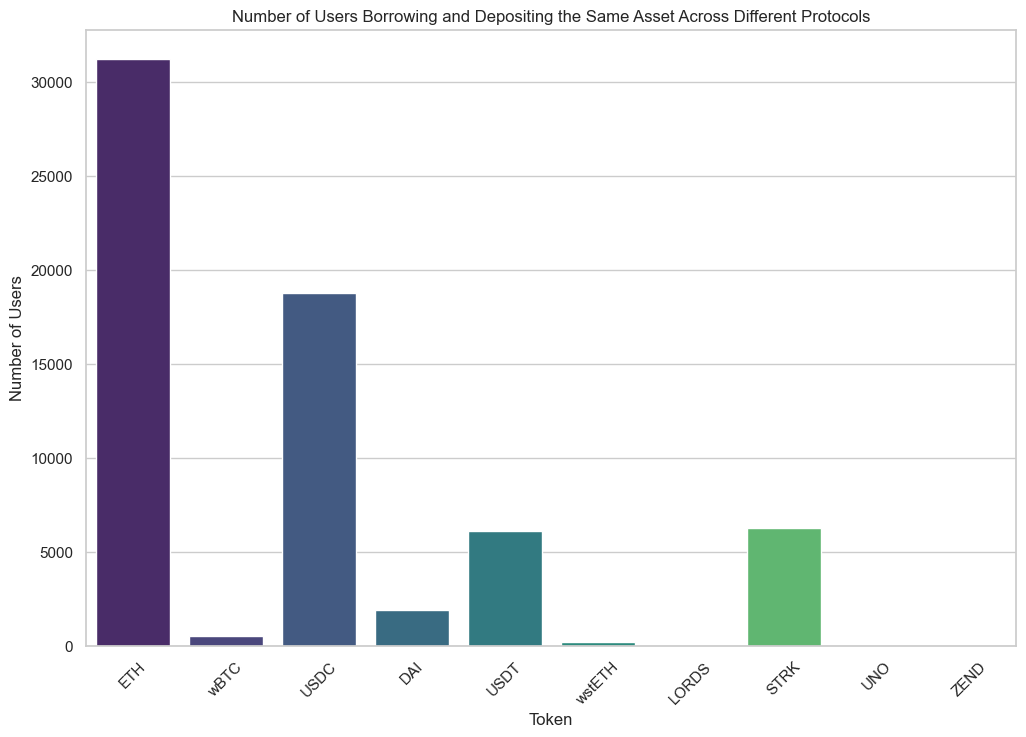

In [68]:
# Convert the results to a DataFrame for plotting
results_loan_states = pd.DataFrame(list(user_counts.items()), columns=['Token', 'User Count'])

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(data=results_loan_states, x='Token', y='User Count', hue='Token', dodge=False, palette='viridis', legend=False)
plt.title('Number of Users Borrowing and Depositing the Same Asset Across Different Protocols')
plt.xlabel('Token')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

### All users accross the all the protocols 

In [69]:
# Count unique users for each token
user_counts = {token: len(users) for token, users in common_users.items()}

# Calculate total users and users involved in borrowing and depositing
total_users = len(all_users)
unique_common_users = set().union(*common_users.values())
total_common_users = len(unique_common_users)

# Print results
print(f"Total number of users: {total_users}")
print(f"Number of users who borrowed and deposited the same asset across different protocols: {total_common_users}")

Total number of users: 1468482
Number of users who borrowed and deposited the same asset across different protocols: 59880


### Visualization Chart

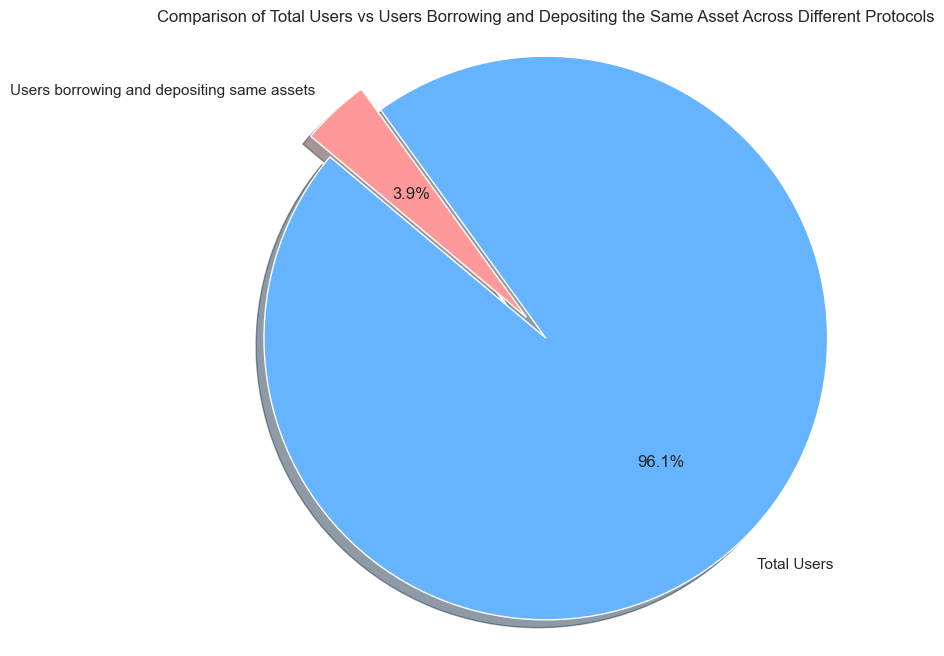

In [70]:
# Plot the results in a pie chart
labels = ['Total Users', 'Users borrowing and depositing same assets']
sizes = [total_users, total_common_users]
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)  # explode the 2nd slice (Borrowing and Depositing users)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Comparison of Total Users vs Users Borrowing and Depositing the Same Asset Across Different Protocols')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## How many users have completed the loop, i.e. deposited token X as collateral, borrowed token Y, deposited Y in another protocol and borrowed X. The loop can contain more than 2 tokens and more then 2 lending protocols.

In [73]:
@dataclass
class UserAction:
    actions: Dict[str, List[Tuple[str, str, float, str]]] = field(default_factory=dict)


# Helper function to parse token amounts
def parse_token_amounts(token_str: str) -> List[Tuple[str, float]]:
    tokens = []
    if token_str:
        token_pairs = token_str.split(', ')
        for token_pair in token_pairs:
            parts = token_pair.split(': ')
            if len(parts) == 2:
                token_name, amount = parts
                tokens.append((token_name, float(amount)))
    return tokens


# Function to extract user actions from the loan_states
def extract_user_actions(loan_states: Dict[str, pd.DataFrame], tokens: List[str]) -> UserAction:
    user_actions = UserAction()
    for protocol, loan_state in loan_states.items():
        for _, row in loan_state.iterrows():
            user = row['User']
            collateral_tokens = parse_token_amounts(row['Collateral'])
            debt_tokens = parse_token_amounts(row['Debt'])

             # Ensure the user key exists in the dictionary
            if user not in user_actions.actions:
                user_actions.actions[user] = []

            # Store collateral actions
            for col_token, col_amount in collateral_tokens:
                if col_token in tokens:
                    user_actions.actions[user].append(('collateral', col_token, col_amount, protocol))

            # Store debt actions
            for debt_token, debt_amount in debt_tokens:
                if debt_token in tokens:
                    user_actions.actions[user].append(('debt', debt_token, debt_amount, protocol))
    return user_actions
    

# Extract user actions
user_actions = extract_user_actions(loan_states, tokens)


# Helper function to check if a loop exists and calculate total dollar amounts
def has_completed_loop(actions: UserAction) -> float:
    token_graph = defaultdict(set)
    total_amount = 0.0
    collateral_amounts = defaultdict(float)
    debt_amounts = defaultdict(float)
    
    for action_type, token, amount, protocol in actions:
        if action_type == 'collateral':
            token_graph['collateral'].add(token)
            collateral_amounts[token] += amount
        elif action_type == 'debt':
            token_graph['debt'].add(token)
            debt_amounts[token] += amount
    
    for token in token_graph['collateral']:
        if token in token_graph['debt']:
            total_amount += min(collateral_amounts[token], debt_amounts[token])
    
    return total_amount


# Calculate total looping users
def count_looping_users(user_actions: UserAction) -> int:
    looping_users = 0
    for user, actions in user_actions.actions.items():
        loop_amount = has_completed_loop(actions)
        if loop_amount > 0:
            looping_users += 1
    return looping_users

# Count the looping users
looping_users = count_looping_users(user_actions)
print(f"Number of users who have completed the loop: {looping_users}")


Number of users who have completed the loop: 53072


## Visualization chart

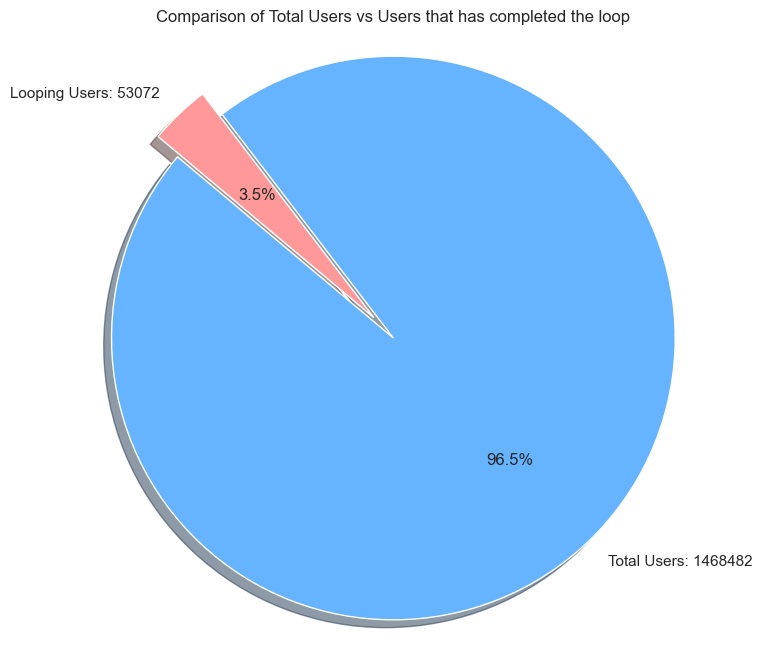

In [74]:
# Plot the results in a pie chart
labels = [F"Total Users: {total_users}", f"Looping Users: {looping_users}"]
sizes = [total_users, looping_users]
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)  # explode the 2nd slice (Looping users)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Comparison of Total Users vs Users that has completed the loop')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## What is the total dollar amount of tokens used in these loops? How much are the deposits multiplicated?

Number of users who have completed the loop: 53072
Total dollar amount of tokens used in loops: 9272776.288299557
Deposit multiplication factor: 0.27851536087500495


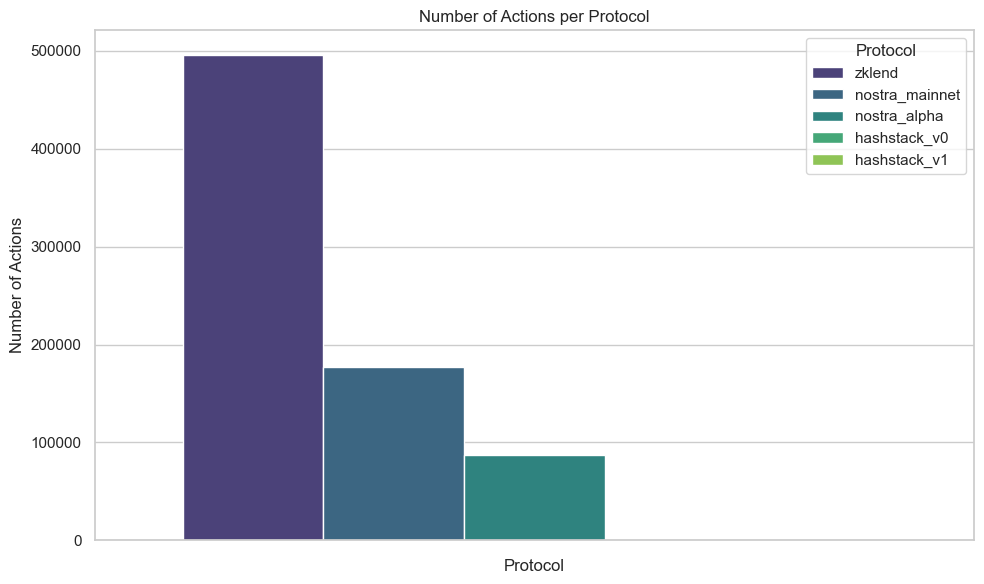

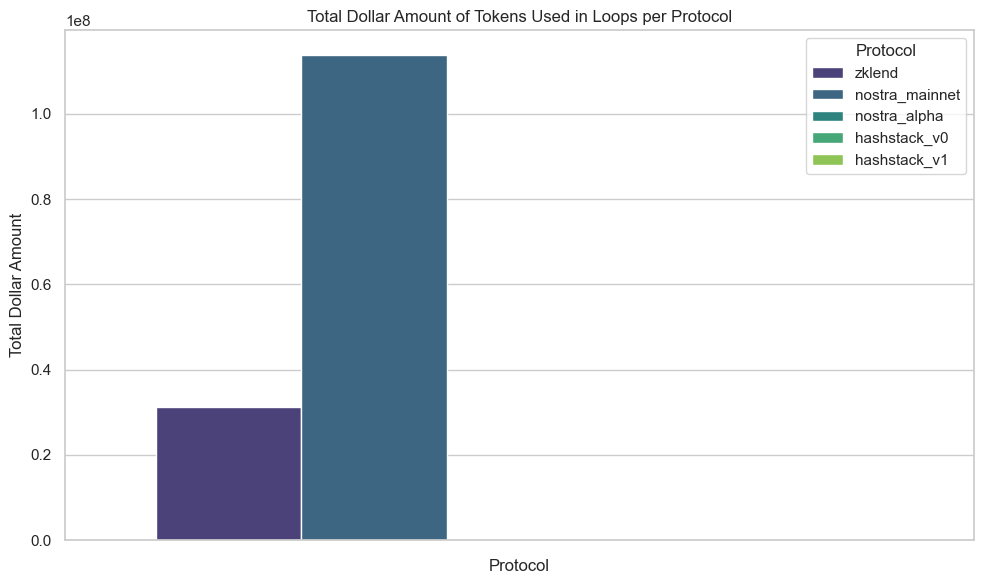

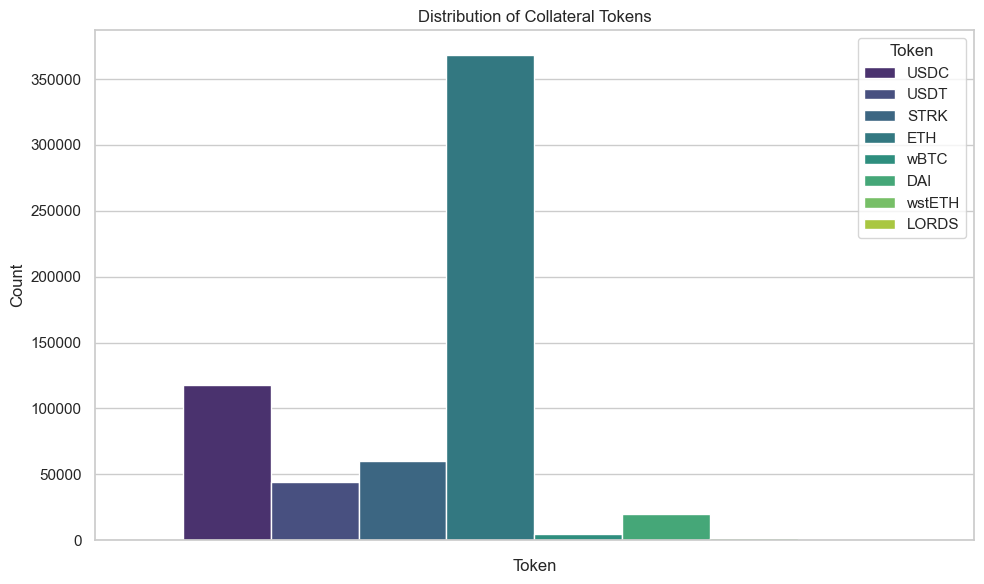

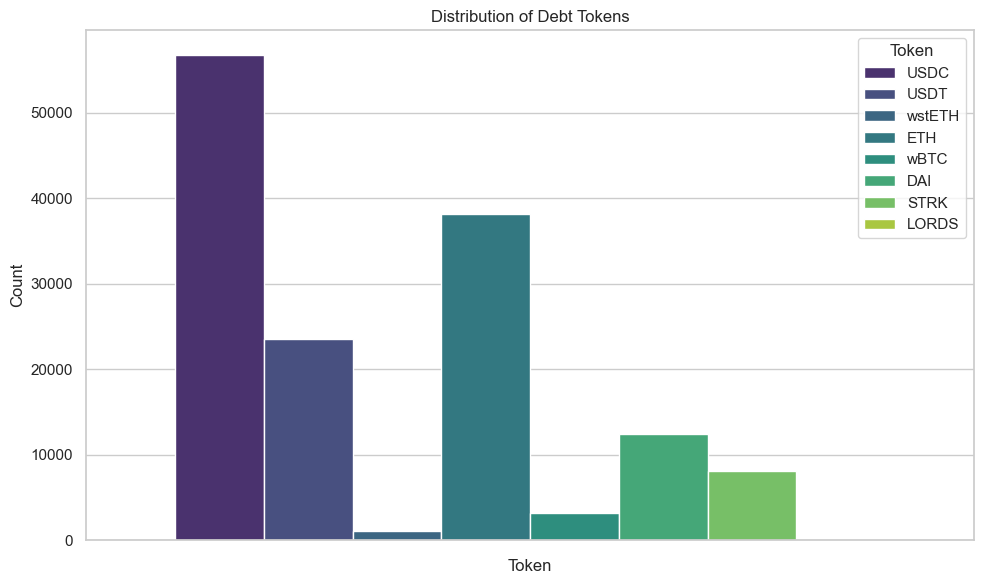

In [77]:
# Calculate total dollar amounts and looping users
def calculate_loop_stats(user_actions: Dict[str, List[Tuple[str, str, float, str]]]) -> Tuple[int, float]:
    total_loop_amount = 0.0
    looping_users = 0
    for user, actions in user_actions.actions.items():
        loop_amount = has_completed_loop(actions)
        if loop_amount > 0:
            looping_users += 1
            total_loop_amount += loop_amount
    return looping_users, total_loop_amount

# Calculate loop stats
looping_users, total_loop_amount = calculate_loop_stats(user_actions)
print(f"Number of users who have completed the loop: {looping_users}")
print(f"Total dollar amount of tokens used in loops: {total_loop_amount}")


# Calculate the deposit multiplication factor
def calculate_deposit_multiplication(user_actions: Dict[str, List[Tuple[str, str, float, str]]], tokens: List[str]) -> float:
    total_collateral = 0.0
    total_debt = 0.0
    for user, actions in user_actions.actions.items():
        for action_type, token, amount, protocol in actions:
            if action_type == 'collateral' and token in tokens:
                total_collateral += amount
            elif action_type == 'debt' and token in tokens:
                total_debt += amount
    
    if total_collateral == 0:
        return 0
    return total_debt / total_collateral

# Calculate deposit multiplication factor
deposit_multiplication_factor = calculate_deposit_multiplication(user_actions, tokens)
print(f"Deposit multiplication factor: {deposit_multiplication_factor}")


# Prepare data for visualizations
protocols = list(parquet_urls.keys())
loop_counts = defaultdict(int)
total_amounts = defaultdict(float)

for user, actions in user_actions.actions.items():
    for action_type, token, amount, protocol in actions:
        if action_type == 'collateral' or action_type == 'debt':
            loop_counts[protocol] += 1
            total_amounts[protocol] += amount

# Convert to DataFrame for plotting
loop_counts_data = pd.DataFrame(list(loop_counts.items()), columns=['Protocol', 'Count'])
total_amounts_data = pd.DataFrame(list(total_amounts.items()), columns=['Protocol', 'Total Amount'])

# Plot the number of users who completed loops per protocol
plt.figure(figsize=(10, 6))
sns.barplot(data=loop_counts_data, hue='Protocol', y='Count', palette='viridis')
plt.title('Number of Actions per Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Actions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the total dollar amount of tokens used in loops per protocol
plt.figure(figsize=(10, 6))
sns.barplot(data=total_amounts_data, hue='Protocol', y='Total Amount', palette='viridis')
plt.title('Total Dollar Amount of Tokens Used in Loops per Protocol')
plt.xlabel('Protocol')
plt.ylabel('Total Dollar Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prepare data for collateral and debt distribution
collateral_counts = defaultdict(int)
debt_counts = defaultdict(int)

for user, actions in user_actions.actions.items():
    for action_type, token, amount, protocol in actions:
        if action_type == 'collateral':
            collateral_counts[token] += 1
        elif action_type == 'debt':
            debt_counts[token] += 1

# Convert to DataFrame for plotting
collateral_counts_data = pd.DataFrame(list(collateral_counts.items()), columns=['Token', 'Count'])
debt_counts_data = pd.DataFrame(list(debt_counts.items()), columns=['Token', 'Count'])

# Plot the distribution of collateral tokens
plt.figure(figsize=(10, 6))
sns.barplot(data=collateral_counts_data, hue='Token', y='Count', palette='viridis')
plt.title('Distribution of Collateral Tokens')
plt.xlabel('Token')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the distribution of debt tokens
plt.figure(figsize=(10, 6))
sns.barplot(data=debt_counts_data, hue='Token', y='Count', palette='viridis')
plt.title('Distribution of Debt Tokens')
plt.xlabel('Token')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Which protocols are subject to the looping behavior the most?

Token: STRK
  Protocol: zklend, Count: 5827
  Protocol: nostra_mainnet, Count: 5827
Token: USDC
  Protocol: nostra_alpha, Count: 6324
  Protocol: zklend, Count: 11372
  Protocol: nostra_mainnet, Count: 7081
  Protocol: hashstack_v0, Count: 14
  Protocol: hashstack_v1, Count: 39
Token: ETH
  Protocol: zklend, Count: 29773
  Protocol: nostra_mainnet, Count: 24041
  Protocol: nostra_alpha, Count: 9945
  Protocol: hashstack_v0, Count: 12
  Protocol: hashstack_v1, Count: 58
Token: wstETH
  Protocol: zklend, Count: 43
  Protocol: nostra_mainnet, Count: 43
Token: wBTC
  Protocol: zklend, Count: 231
  Protocol: nostra_mainnet, Count: 221
  Protocol: nostra_alpha, Count: 12
Token: DAI
  Protocol: zklend, Count: 1075
  Protocol: nostra_mainnet, Count: 521
  Protocol: nostra_alpha, Count: 587
Token: USDT
  Protocol: nostra_alpha, Count: 2595
  Protocol: zklend, Count: 3819
  Protocol: hashstack_v0, Count: 4
  Protocol: nostra_mainnet, Count: 1790
  Protocol: hashstack_v1, Count: 19


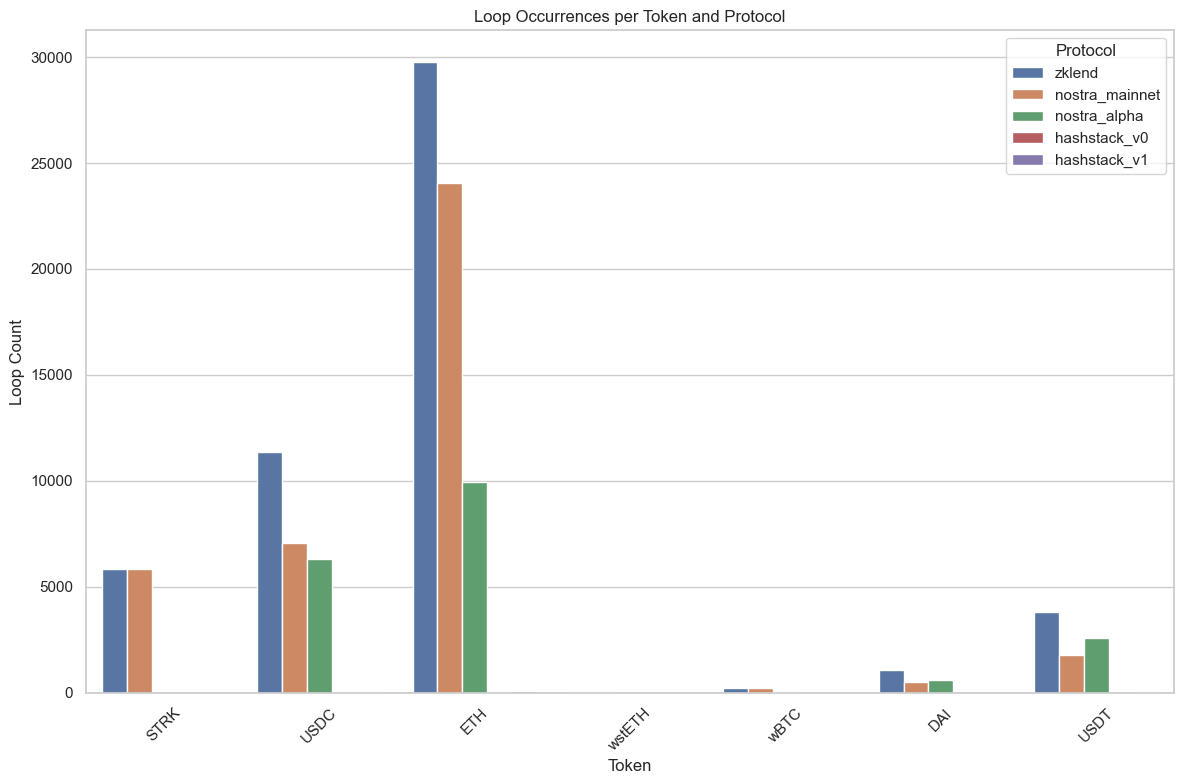

In [79]:
# Function to track loop occurrences for each token and protocol
def track_loop_occurrences(user_actions: Dict[str, List[Tuple[str, str, float, str]]],tokens: List[str]) -> Dict[str, Dict[str, int]]:
    loop_occurrences = defaultdict(lambda: defaultdict(int))
    
    for user, actions in user_actions.actions.items():
        # Create a set to track protocols involved in a loop for the user
        user_protocols = defaultdict(set)
        
        for action_type, token, amount, protocol in actions:
            if token in tokens:
                user_protocols[token].add(protocol)
        
        for token, protocols in user_protocols.items():
            if len(protocols) > 1:
                for protocol in protocols:
                    loop_occurrences[token][protocol] += 1
    
    return loop_occurrences

# Track loop occurrences
loop_occurrences = track_loop_occurrences(user_actions, tokens)

# Print loop occurrences for each token and protocol
for token, protocol_counts in loop_occurrences.items():
    print(f"Token: {token}")
    for protocol, count in protocol_counts.items():
        print(f"  Protocol: {protocol}, Count: {count}")

# Convert loop occurrences to a DataFrame for visualization
loop_data = []
for token, protocol_counts in loop_occurrences.items():
    for protocol, count in protocol_counts.items():
        loop_data.append({'Token': token, 'Protocol': protocol, 'Count': count})

looping_data = pd.DataFrame(loop_data)

# Plot the loop occurrences
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

sns.barplot(data=looping_data, x='Token', y='Count', hue='Protocol')
plt.title('Loop Occurrences per Token and Protocol')
plt.ylabel('Loop Count')
plt.xlabel('Token')
plt.xticks(rotation=45)
plt.legend(title='Protocol')
plt.tight_layout()

plt.show()

# Other visualizations

## Token usage as Collateral and Debt

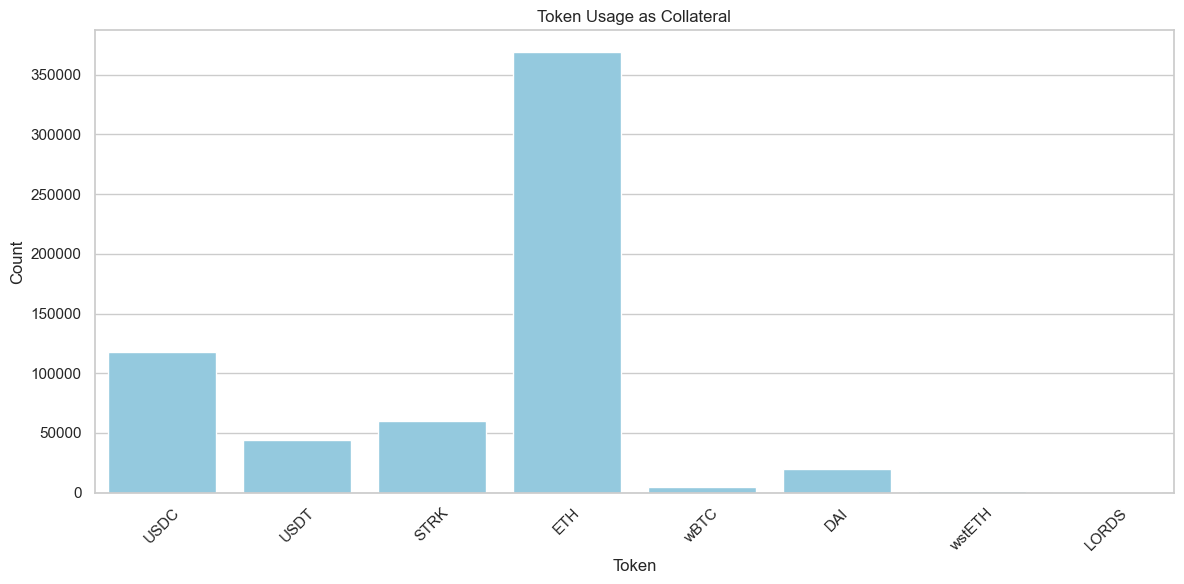

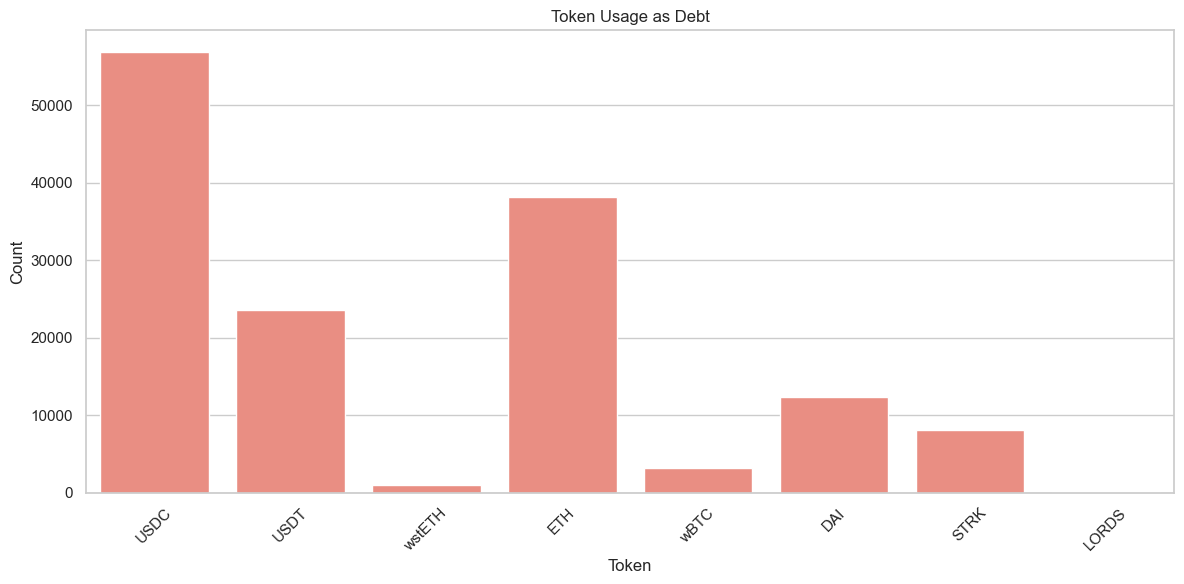

In [81]:
# Function to count token usage in collateral and debt
def count_token_usage(user_actions: UserAction) -> Tuple[Dict[str, int], Dict[str, int]]:
    collateral_count = defaultdict(int)
    debt_count = defaultdict(int)

    for actions in user_actions.actions.values():
        for action_type, token, amount, protocol in actions:
            if action_type == 'collateral':
                collateral_count[token] += 1
            elif action_type == 'debt':
                debt_count[token] += 1

    return collateral_count, debt_count

# Count token usage
collateral_count, debt_count = count_token_usage(user_actions)

# Convert counts to DataFrames for visualization
collateral_token_usage = pd.DataFrame(list(collateral_count.items()), columns=['Token', 'Count'])
debt_token_usage = pd.DataFrame(list(debt_count.items()), columns=['Token', 'Count'])

# Plot collateral usage
plt.figure(figsize=(12, 6))
sns.barplot(data=collateral_token_usage, x='Token', y='Count', color='skyblue')
plt.title('Token Usage as Collateral')
plt.ylabel('Count')
plt.xlabel('Token')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot debt usage
plt.figure(figsize=(12, 6))
sns.barplot(data=debt_token_usage, x='Token', y='Count', color='salmon')
plt.title('Token Usage as Debt')
plt.ylabel('Count')
plt.xlabel('Token')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Total debt by token

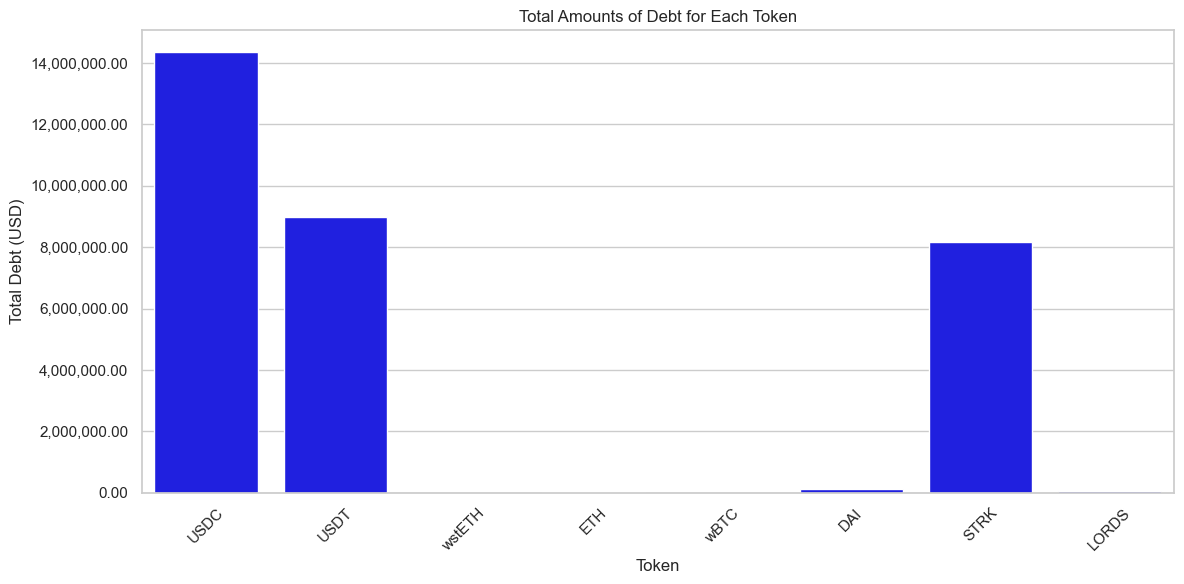

In [82]:
# Function to calculate total amounts of debt for each token
def calculate_total_debt(user_actions: DefaultDict[str, List[Tuple[str, str, float, str]]]) -> Tuple[DefaultDict[str, int], DefaultDict[str, int]]:
    total_debt = defaultdict(float)

    for actions in user_actions.actions.values():
        for action_type, token, amount, protocol in actions:
            if action_type == 'debt':
                total_debt[token] += amount

    return total_debt

# Calculate total debt
total_d = calculate_total_debt(user_actions)

# Convert total debt to DataFrame for visualization
total_debt = pd.DataFrame(list(total_debt.items()), columns=['Token', 'Total Debt'])

# Plot total debt amounts
plt.figure(figsize=(12, 6))
sns.barplot(data=total_debt, x='Token', y='Total Debt', color='blue')

# Format y-axis to show more precise amounts
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.2f}'))

plt.title('Total Amounts of Debt for Each Token')
plt.ylabel('Total Debt (USD)')
plt.xlabel('Token')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Distribution of Collateral and Debt Across Protocols

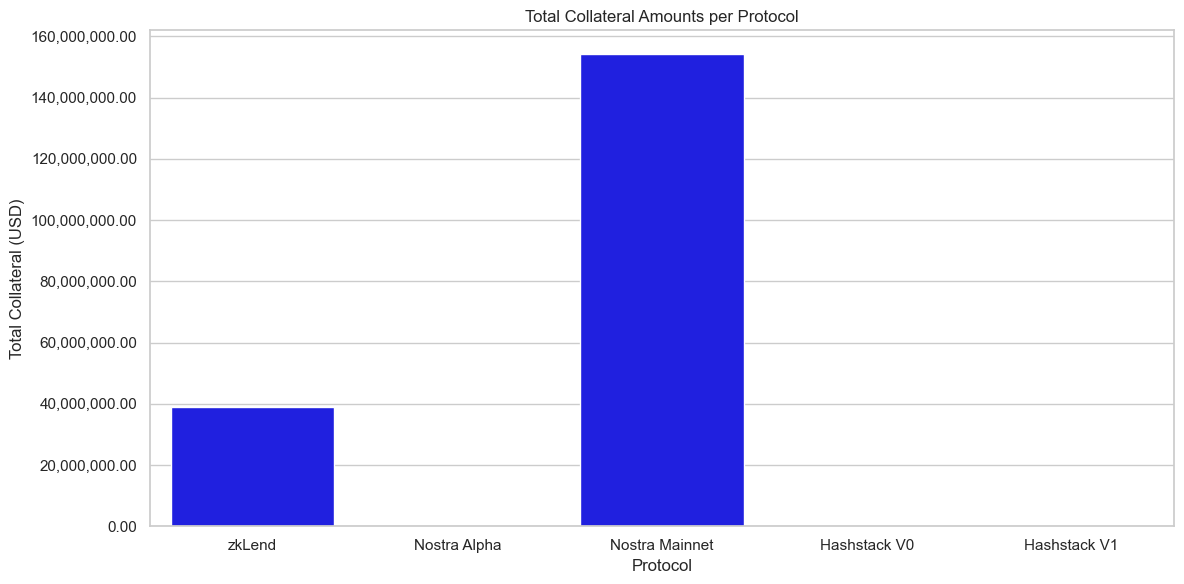

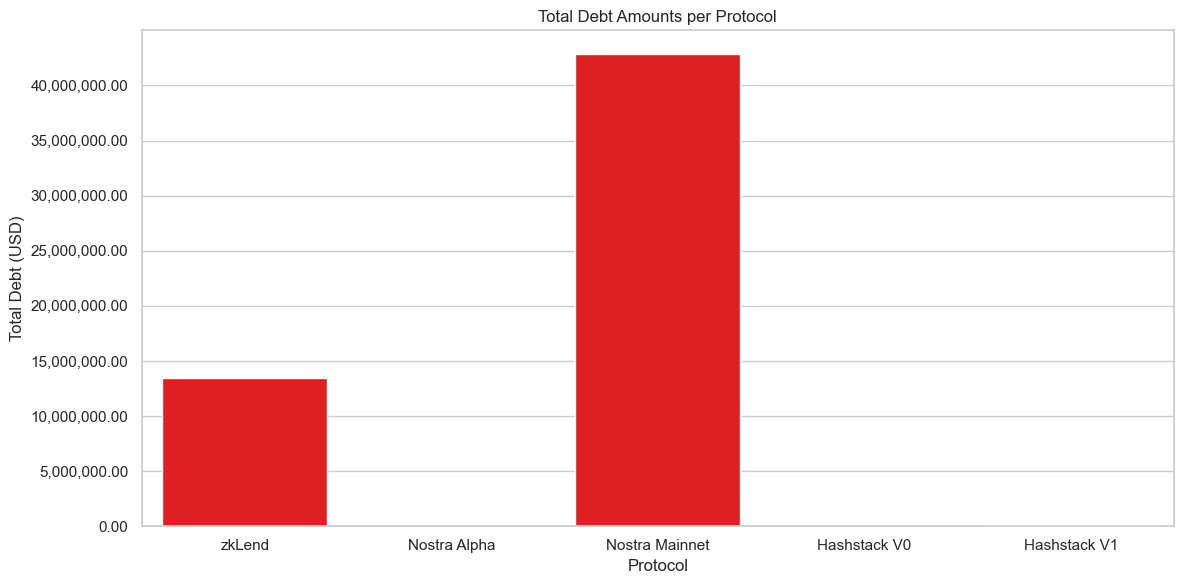

In [83]:
# Total collateral per protocol
total_collateral_per_protocol = pd.concat([
    loan_state[['Collateral (USD)', 'Protocol']].groupby('Protocol').sum().reset_index() 
    for loan_state in loan_states.values()
])

# Total debt per protocol
total_debt_per_protocol = pd.concat([
    loan_state[['Debt (USD)', 'Protocol']].groupby('Protocol').sum().reset_index() 
    for loan_state in loan_states.values()
])


# Plot total collateral per protocol
plt.figure(figsize=(12, 6))
sns.barplot(data=total_collateral_per_protocol, x='Protocol', y='Collateral (USD)', color='blue')

# Format y-axis to show more precise amounts
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.2f}'))

plt.title('Total Collateral Amounts per Protocol')
plt.ylabel('Total Collateral (USD)')
plt.xlabel('Protocol')
plt.tight_layout()
plt.show()

# Plot total debt per protocol
plt.figure(figsize=(12, 6))
sns.barplot(data=total_debt_per_protocol, x='Protocol', y='Debt (USD)', color='red')

# Format y-axis to show more precise amounts
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.2f}'))

plt.title('Total Debt Amounts per Protocol')
plt.ylabel('Total Debt (USD)')
plt.xlabel('Protocol')
plt.tight_layout()
plt.show()


## User activity per protocol

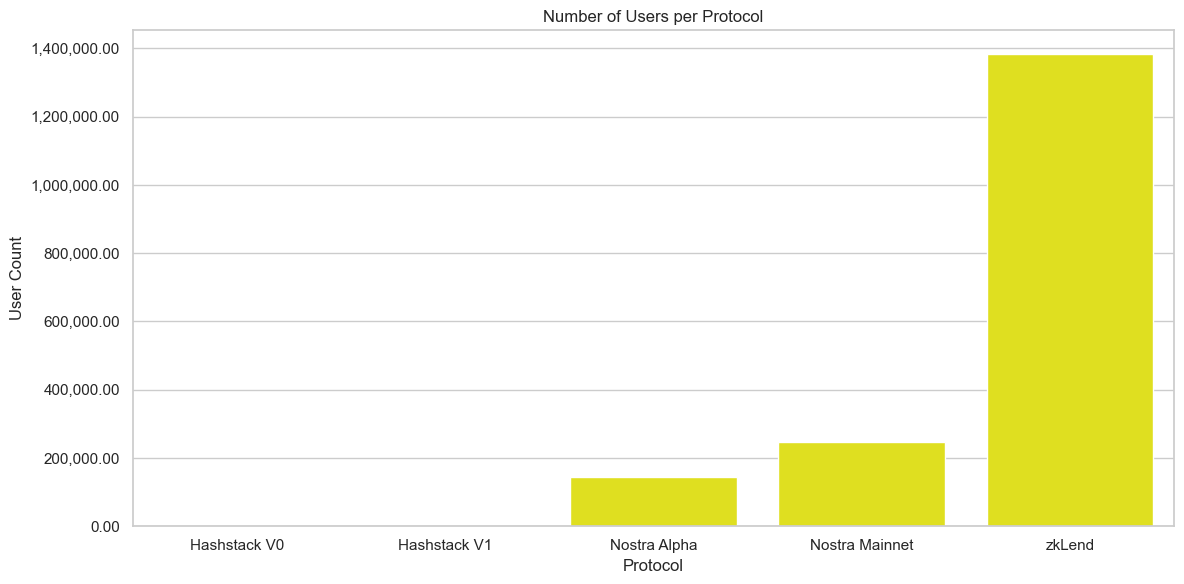

In [84]:
# Combine all loan_states to analyze health factors
combined_loan_states = pd.concat(loan_states.values())

# Number of users per protocol
users_per_protocol = combined_loan_states.groupby('Protocol')['User'].nunique().reset_index()
users_per_protocol.columns = ['Protocol', 'User Count']

# Plot number of users per protocol
plt.figure(figsize=(12, 6))
sns.barplot(data=users_per_protocol, x='Protocol', y='User Count', color='yellow')

# Format y-axis to show more precise amounts
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.2f}'))

plt.title('Number of Users per Protocol')
plt.ylabel('User Count')
plt.xlabel('Protocol')
plt.tight_layout()
plt.show()

## Average collateral and debt per user across protocols

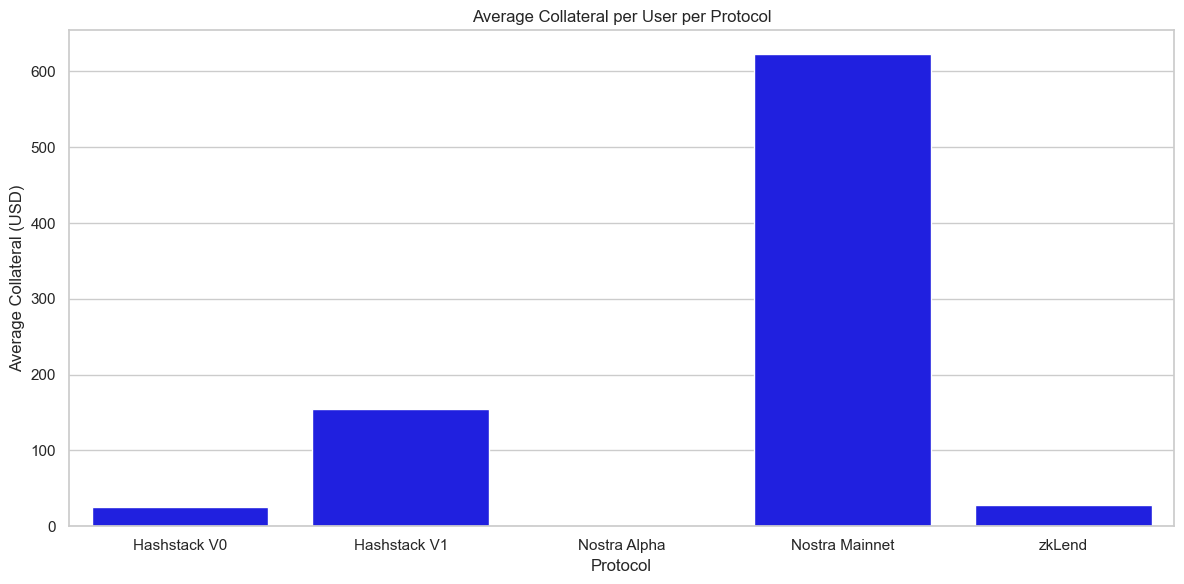

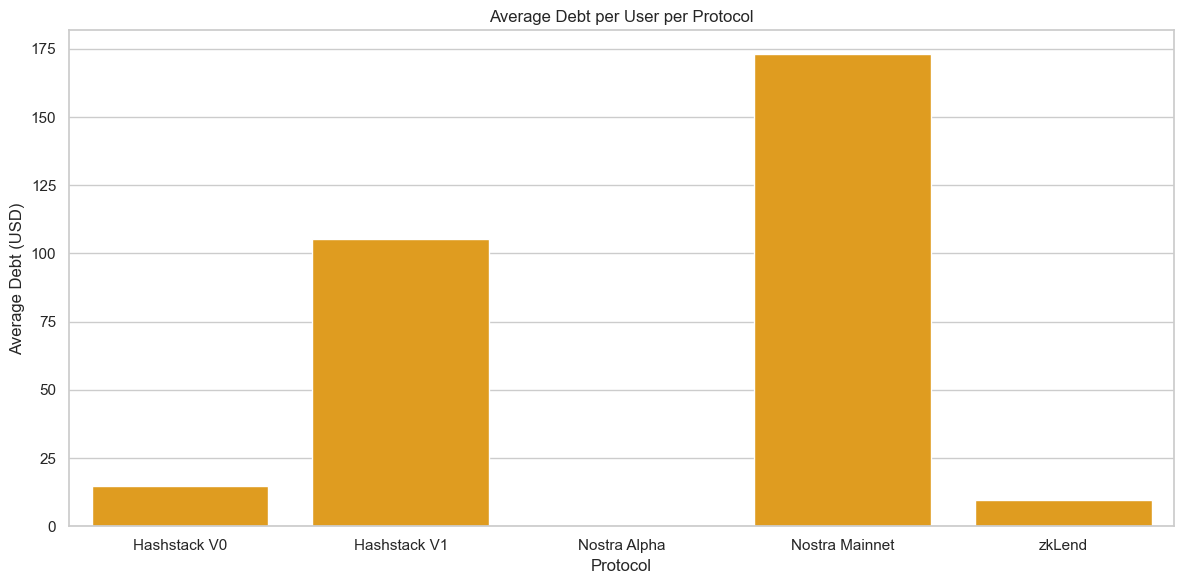

In [85]:
# Average collateral and debt per user per protocol
avg_collateral_debt_per_user = combined_loan_states.groupby('Protocol')[['Collateral (USD)', 'Debt (USD)']].mean().reset_index()

# Plot average collateral per user per protocol
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_collateral_debt_per_user, x='Protocol', y='Collateral (USD)', color='blue')
plt.title('Average Collateral per User per Protocol')
plt.ylabel('Average Collateral (USD)')
plt.xlabel('Protocol')
plt.tight_layout()
plt.show()

# Plot average debt per user per protocol
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_collateral_debt_per_user, x='Protocol', y='Debt (USD)', color='orange')
plt.title('Average Debt per User per Protocol')
plt.ylabel('Average Debt (USD)')
plt.xlabel('Protocol')
plt.tight_layout()
plt.show()
